<a href="https://colab.research.google.com/github/Prateek2901/Prateek2901.github.io/blob/master/Siamese_network_CNN_Modular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""Basic Python"""
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.display import SVG
import random

In [0]:
"""Imports for Neural Network Construction"""
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

In [0]:
"""Helper libraries"""
import numpy as np #Numpy is used for Array based operations
import matplotlib.pyplot as plt # Matplotlib is used for Visualization

In [0]:
"""Setting Reproducible Factor"""
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [0]:
def get_fashion_MNIST():
	"""Loading Fashon MNIST from tensorlfow.keras.datasets"""
	fashion_mnist = keras.datasets.fashion_mnist
	#Getting the basic Predefined Train/Test Split from "keras.datasets"
	(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
	# Resizing images to 28X28 with 1 Channel
	train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
	test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))
	# Converting Image data to Float to facilitate computation
	train_images = train_images.astype('float32')
	test_images = test_images.astype('float32')
	# Normalizing Image data
	train_images /= 255
	test_images /= 255
	# Data Collection
	images_master = np.concatenate((train_images,test_images),axis=0)
	labels_master = np.concatenate((train_labels,test_labels),axis=0)
	return images_master,labels_master

In [0]:
def get_labels():
	# Class Labels
	label =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
	# Mapping for Codes and Class Names.
	class_mapping ={ j:i for i,j in enumerate(label)}
	return label,class_mapping

In [0]:
def get_split(classes,images,labels):
  """
  Making mask to only select the required classes
  Keyword arguments:
  classes -- to filter only the classes mentioned
  images -- images to be filtered
  labels -- labels for the filtered images
  """
  mask = np.array([i in classes for i in labels])
  return images[mask],labels[mask]

In [0]:
def plot_data(mapping,images,labels):
  """
  Plotting 25 images in 5X5 matrix along with its label
  Keyword arguments:
  mapping -- Class to String mapping for labels in visualization output
  images -- images for visualization
  labels -- labels for images  
  """
  # Mapping category code to labels
  cat_name = {v: k for k, v in mapping.items()}
  
  plt.figure(figsize=(10,10))
  for i in range(25):
	    plt.subplot(5,5,i+1) #This creates 5X5 matrix of placeholder images
	    plt.xticks([]) #Masking X Axis label
	    plt.yticks([]) #Masking Y Axis label
	    plt.grid(False) #Removing Grid from plot
	    plt.imshow(images[i].reshape(28,28), cmap=plt.cm.binary) #Plotting B&W image
	    plt.xlabel(cat_name[labels[i]]) #Adding Class label
  plt.show()

In [0]:
def train_test_split(images,labels,train_split=.80):
  """
  Making a train - test split based on the ratio mentioned.
  Keyword arguments:
  images -- images for split
  labels -- labels for images
  train_split -- ratio of training sample wrt to all the images.
  """
  if train_split>1:# this condition will take care of the ratio if its out of 100
    train_split/=100
  # Finding the numbers of images to be part of train - test split 
  index = int(images.shape[0]*train_split)
  # First N images are taken as Training Images
  training_images = images[:index]
  training_label = labels[:index]
  # Next N images are taken as Testing Images
  testing_images = images[index:]
  testing_label = labels[index:]
  return training_images,training_label,testing_images,testing_label

In [0]:
def eu_distance(vects):
  """
  Finding Euclidean Distance
  Keyword arguments:
  vects -- cartesian coordinates for distance calcutaion
  """
  x, y = vects # Taking X & Y values.
  sum_square = K.sum(K.square(x - y), axis=1, keepdims=True) # Calculating Squared Distance
  return K.sqrt(K.maximum(sum_square, K.epsilon())) # Calculating Euclidean Distance

In [0]:
def output_shape(shapes):
  """
  Calculating Output Dimension of NN
  Keyword arguments:
  shapes -- tuple with dimension information of the images fed to network
  """
  shape1, shape2 = shapes #Getting Shape of the 2 images of Siamese network
  return (shape1[0], 1)  

In [0]:
def contrastive_loss(y_true, y_pred):
  """
  Creating Loss Function
  Keyword arguments:
  y_true -- true labels
  y_pred -- predicted labels
  """
  margin = 1 # The margin determines how far the embeddings of a negative pair should be pushed apart.
  square_pred = K.square(y_pred) # Squared Distance of Euclidean Distance for similar pair
  margin_square = K.square(K.maximum(margin - y_pred, 0)) # Squared Distance of Euclidean Distance for dissimilar pair
  return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [0]:
def create_pairs(images, index,model_labels):
  """
  Creating Pairs of similar & dissimilar Images
  Keyword arguments:
  images -- images for creating pairs
  index -- index of labels for which the pairs are requried
  model_labels -- all 10 class labels
  """ 
  pairs,labels = [],[]
  #This condition takes care of imbalance proportion of images. 
  #It makes pairs based on the minimum number of images present in a class.
  n = min([len(index[d]) for d in range(len(model_labels))]) - 1

  #Iterating each label to create pairs.
  for i in range(len(model_labels)):
    # Making pairs of minimum count of images of a class.
    for j in range(n):
      #This part makes similar pairs by taking images of same category.
      index1, index2 = index[i][j], index[i][j + 1]
      pairs += [[images[index1], images[index2]]]
      #This part makes dissimilar pairs by taking images of different category.
      inc = random.randrange(1, len(model_labels))
      dn = (i + inc) % len(model_labels)
      index1, index2 = index[i][j], index[dn][j]
      # Adding pairs generated to list.
      pairs += [[images[index1], images[index2]]]
      labels += [1, 0]
  return np.array(pairs), np.array(labels)

In [0]:
def finding_pairs(model_labels,label,images):
  """
  Utility function to get pair of images for Siamese Network
  Keyword arguments:
  model_labels -- all 10 class labels
  images -- images for finding pairs
  labels -- labels for images
  """
  index = [np.where(label == i)[0] for i in model_labels] # Index of labels to be considered for making pairs
  pairs_x, pairs_y = create_pairs(images, index,model_labels) # Getting Similar & Dissimilar pairs.
  pairs_x = pairs_x.reshape((pairs_x.shape[0], 2,28, 28)) # Resizing Image to make consistent Network.
  return pairs_x,pairs_y

In [0]:
def cnn_network(inputShape):
  """
  Making a CNN with 2 Conv Layer Units, 1 Flatten Units & 1 FCN.
  Keyword arguments:
  input_shape -- imput dimension for model
  """
  # CNN Layer 1
  input = Input(shape=inputShape,name='Image_Input_Layer')#(2,28,28))
  cnn11 = Conv2D(32, (3, 3), padding='same', activation='relu',name='Convolution_Layer11')(input)
  normal11 = BatchNormalization(axis=-1,name='BatchNormalization_Layer11')(cnn11)
  cnn12 = Conv2D(32, (3, 3), padding='same', activation='relu',name='Convolution_Layer12')(normal11)
  normal12 = BatchNormalization(axis=-1,name='BatchNormalization_Layer12')(cnn12)
  drop11 = Dropout(0.25,name='Dropout_Layer12')(normal12)
  # CNN Layer 2
  cnn21 = Conv2D(64, (3, 3), padding='same', activation='relu',name='Convolution_Layer21')(drop11)
  normal21 = BatchNormalization(axis=-1,name='BatchNormalization_Layer21')(cnn21)
  cnn22 = Conv2D(64, (3, 3), padding='same', activation='relu',name='Convolution_Layer22')(normal21)
  normal22 = BatchNormalization(axis=-1,name='BatchNormalization_Layer22')(cnn22)
  drop21 = Dropout(0.25,name='Dropout_Layer22')(normal22)
  # Flatten Layer 
  Flatten31 = Flatten(name='Flatten_Layer3')(drop21)
  Dense31 = Dense(512, activation='relu',name='Dense_Layer31')(Flatten31)
  normal31 = BatchNormalization(axis=-1,name='BatchNormalization_Layer31')(Dense31)
  drop31 = Dropout(0.5,name='Dropout_Layer31')(normal31)
  # ANN Layer
  Dense41 = Dense(128, activation='relu',name='Dropout_Layer42')(drop31)
  return Model(input, Dense41,name='CNN')

In [0]:
def compute_accuracy(y_true, y_pred):
  '''
  Compute classification accuracy with a 60% threshold on distances.
  Keyword arguments:
  y_true -- true labels
  y_pred -- predicted labels
  '''
  pred = y_pred.ravel() < 0.6
  return np.mean(pred == y_true)

In [0]:
def accuracy(y_true, y_pred):
  """
  Using Cut-Off of 60% probability to decide if the results are good
  Keyword arguments:
  y_true -- true labels
  y_pred -- predicted labels
  """
  return K.mean(K.equal(y_true, K.cast(y_pred < 0.6, y_true.dtype)))

In [0]:
def siamese_network(input_shape = (1,28,28)):
  """
  Making a Siamese network with 2 Input & 1 Output.
  Keyword arguments:
  input_shape -- imput dimension for model
  """
  common_network = cnn_network(input_shape)# Taking Base CNN Model
  pair_img_1 = Input(shape=input_shape,name='Pair_Image1') # Input for Image 1
  pair_img_2 = Input(shape=input_shape,name='Pair_Image2') # Input for Image 2
  ntwork_wt_1 = common_network(pair_img_1) # Sharing CNN for Image 1 
  ntwork_wt_2 = common_network(pair_img_2) # Sharing CNN for Image 2
  distance = Lambda(eu_distance,output_shape=output_shape,name='Siamese_Loss')([ntwork_wt_1, ntwork_wt_2]) # Adding Custom Layer for Similarity Calculations
  model = Model([pair_img_1, pair_img_2], distance) # Joining Loss Functions and Shared Network to once Unit.
  return model

In [0]:
def define_model(model,nested=0):
  """Showing Architecture of the Network

  Keyword arguments:
  model -- defined NN model
  nested -- comes handly if network is stacked or nested.
  """
  tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=nested,
    dpi=96)

In [0]:
def plot_model_training(history):
  """Visualizing the Accuracy & Losses wrt time

    Keyword arguments:
    history -- history variables packs values like accuracy, validation accuracy, loss & validation loss
  """
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch(Time)')
  plt.grid()
  plt.legend(['Train', 'Test'], loc='lower right')

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch(Time)')
  plt.grid()
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

In [0]:
def predict(pairs_x,pairs_y):
  """
  Use this for calculating accuracy pf the predictions
  Keyword arguments:
  pairs_x -- Images for network
  pairs_y -- True labels for Images to match with predictions
  """
  y_pred = model.predict([pairs_x[:, 0].reshape(pairs_x.shape[0], 1, 28, 28), pairs_x[:, 1].reshape(pairs_x.shape[0], 1, 28, 28)])
  acc = compute_accuracy(pairs_y, y_pred)
  return acc

#Verification of Loss Function

In [22]:
#verifying loss function for dissimilar points
try:
    i = np.random.randint(2, size=10)
    j = np.random.randint(2, size=10)
    print(i)
    print(j)
    result = contrastive_loss(K.variable(i), K.variable(j))
    assert K.eval(result) == 1
except AssertionError:
    print ('False')

[1 1 0 0 1 1 1 1 1 0]
[0 1 0 1 1 0 0 1 0 0]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
False


In [23]:
#verifying loss function for similar points
try:
    i = np.random.randint(2, size=10)
    print(i)
    result = contrastive_loss(K.variable(i), K.variable(i))
    assert K.eval(result) == 1
except AssertionError:
    print ('False')

[0 1 0 0 1 0 0 0 1 0]


# CNN

In [0]:
# Loading the data
images,labels=get_fashion_MNIST()

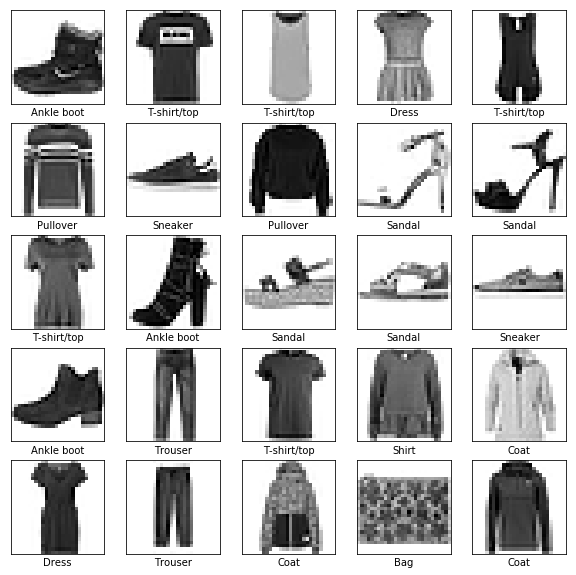

In [25]:
# Getting the String Equivalent of the Class codes
label_str,label_mapping = get_labels()
# Plotting Images to understanding
plot_data(label_mapping,images,labels)

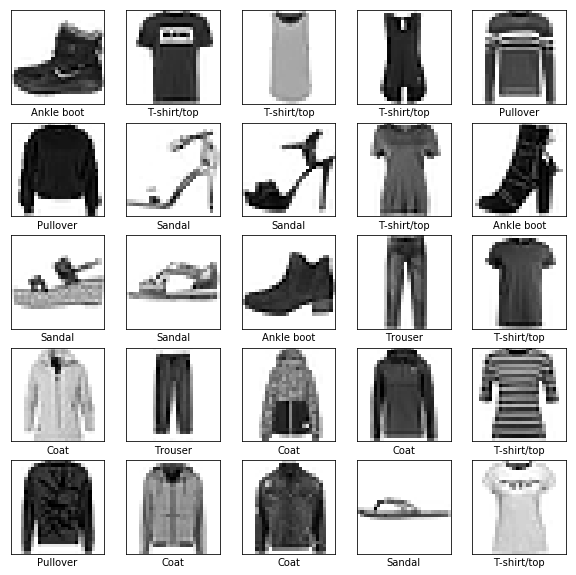

In [26]:
# Preparing Data for Model Training & Validation
modeling_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Coat', 'Sandal', 'Ankle boot']
# Getting Class codes of the above mentioned category
modeling_index = [label_mapping[i] for i in modeling_classes]
# Filtering based on the Class codes.
modeling_x,modeling_y = get_split(modeling_index,images,labels)
# Plotting Images to understanding
plot_data(label_mapping,modeling_x,modeling_y)

In [0]:
training_images,training_label,testing_images,testing_label=train_test_split(modeling_x,modeling_y)

In [0]:
model_labels = (0, 1, 2, 4, 5, 9)
train_pairs_x,train_pairs_y=finding_pairs(model_labels,training_label,training_images)
test_pairs_x,test_pairs_y=finding_pairs(model_labels,testing_label,testing_images)

#Verification of data

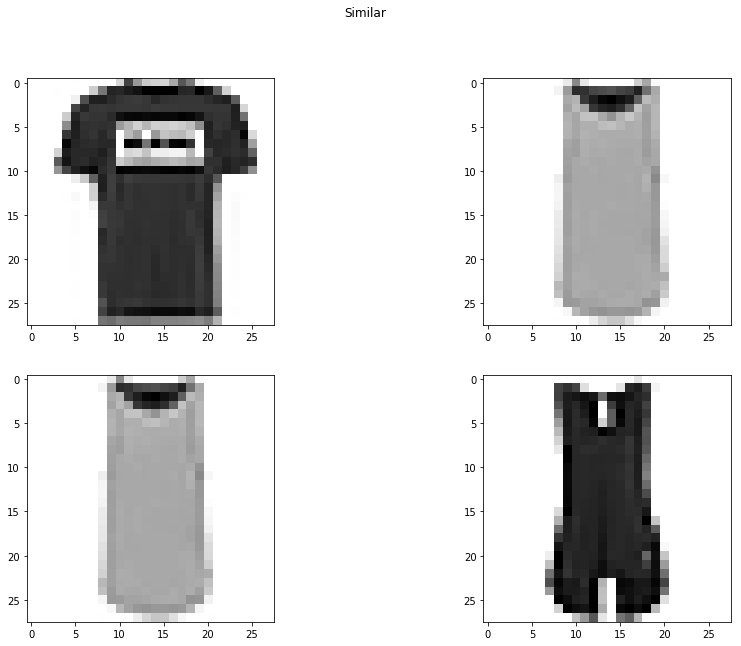

In [29]:
fig = plt.figure(figsize=(15,10))
ax=fig.add_subplot(2,2,1)
ax.imshow(train_pairs_x[0, 0].reshape(28,28), cmap=plt.cm.binary)
ax=fig.add_subplot(2,2,2)
ax.imshow(train_pairs_x[0, 1].reshape(28,28), cmap=plt.cm.binary)
ax=fig.add_subplot(2,2,3)
ax.imshow(train_pairs_x[2, 0].reshape(28,28), cmap=plt.cm.binary)
ax=fig.add_subplot(2,2,4)
ax.imshow(train_pairs_x[2, 1].reshape(28,28), cmap=plt.cm.binary)
fig.suptitle('Similar');

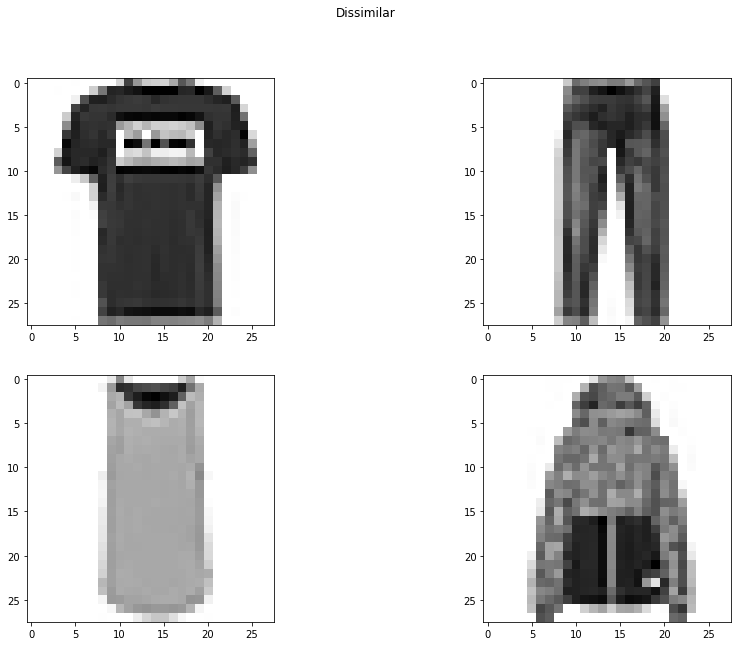

In [30]:
fig = plt.figure(figsize=(15,10))
ax=fig.add_subplot(2,2,1)
ax.imshow(train_pairs_x[1, 0].reshape(28,28), cmap=plt.cm.binary)
ax=fig.add_subplot(2,2,2)
ax.imshow(train_pairs_x[1, 1].reshape(28,28), cmap=plt.cm.binary)
ax=fig.add_subplot(2,2,3)
ax.imshow(train_pairs_x[3, 0].reshape(28,28), cmap=plt.cm.binary)
ax=fig.add_subplot(2,2,4)
ax.imshow(train_pairs_x[3, 1].reshape(28,28), cmap=plt.cm.binary)
fig.suptitle('Dissimilar');

In [31]:
model = siamese_network()
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
history =model.fit(
	[train_pairs_x[:, 0].reshape(train_pairs_x.shape[0], 1, 28, 28), 
	train_pairs_x[:, 1].reshape(train_pairs_x.shape[0], 1,28, 28)], 
	train_pairs_y,
    batch_size=128,
    epochs=10,
    validation_data=(
    	[test_pairs_x[:, 0].reshape(test_pairs_x.shape[0], 1, 28, 28),
    	test_pairs_x[:, 1].reshape(test_pairs_x.shape[0],1, 28, 28)],
    	test_pairs_y)
    )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 66984 samples, validate on 16536 samples
Epoch 1/10
66984/66984 [==============================] - 13s 191us/sample - loss: 5.9068 - accuracy: 0.6842 - val_loss: 0.1038 - val_accuracy: 0.8500
Epoch 2/10
66984/66984 [==============================] - 10s 151us/sample - loss: 0.1190 - accuracy: 0.9010 - val_loss: 0.0712 - val_accuracy: 0.9080
Epoch 3/10
66984/66984 [==============================] - 10s 150us/sample - loss: 0.0790 - accuracy: 0.9280 - val_loss: 0.0531 - val_accuracy: 0.9367
Epoch 4/10
66984/66984 [==============================] - 10s 151us/sample - loss: 0.0671 - accuracy: 0.9367 - val_loss: 0.0530 - val_accuracy: 0.9402
Epoch 5/10
66984/66984 [==============================] - 10s 152us/sample - loss: 0.0642 - accuracy: 0.9406 - val_loss: 0.3871 - val_accuracy: 0.9429
Epoch 6/10
66984/66984 [==============================] - 10s 153us/sample - loss: 0.0604 - accuracy:

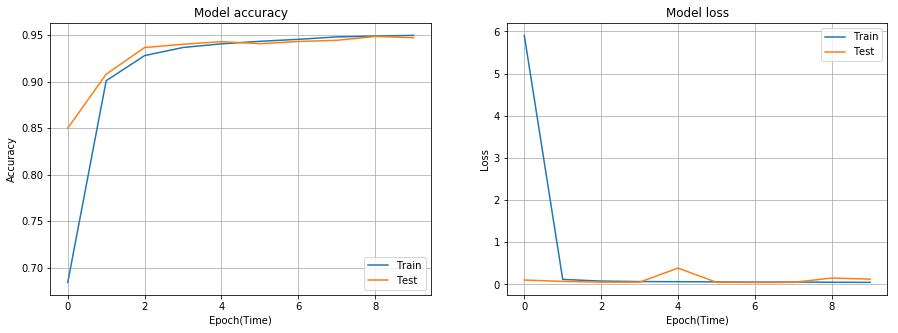

In [32]:
plot_model_training(history)

In [33]:
y_pred = model.predict([train_pairs_x[:, 0].reshape(train_pairs_x.shape[0], 1, 28, 28),
                        train_pairs_x[:, 1].reshape(train_pairs_x.shape[0], 1, 28, 28)])
tr_acc = compute_accuracy(train_pairs_y, y_pred)
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))

* Accuracy on training set: 95.43%


In [34]:
y_pred = model.predict([test_pairs_x[:, 0].reshape(test_pairs_x.shape[0], 1,28, 28),
                        test_pairs_x[:, 1].reshape(test_pairs_x.shape[0], 1,28, 28)])
te_acc = compute_accuracy(test_pairs_y, y_pred)
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on test set: 94.69%


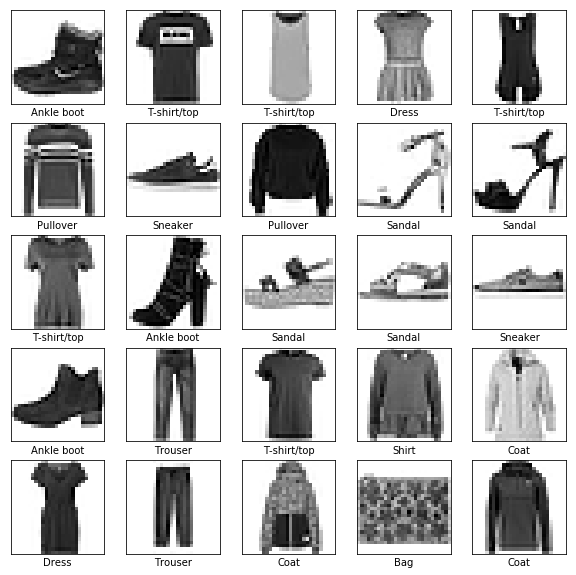

In [35]:
all_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# Getting Class codes of the above mentioned category
modeling_index = [label_mapping[i] for i in all_classes]
# Filtering based on the Class codes.
all_x,all_y = get_split(modeling_index,images,labels)
# Plotting Images to understanding
plot_data(label_mapping,all_x,all_y)

In [0]:
# Validation based on all the classes
all_labels = [i for i in range(10)]
# Finding Similar & Dissimilar pairs for classes mentioned.
all_pairs_x, all_pairs_y = finding_pairs(all_labels, all_y,all_x)

In [37]:
# Taking Prediciton using COmposit Network
y_pred = model.predict([all_pairs_x[:, 0].reshape((all_pairs_x.shape[0], 1,28, 28)), all_pairs_x[:, 1].reshape((all_pairs_x.shape[0], 1,28, 28))])
# Calculating Accuracy based on 60% cut off
te_acc = compute_accuracy(all_pairs_y, y_pred)
print('* Accuracy on complete set: %0.2f%%' % (100 * te_acc))

* Accuracy on complete set: 82.79%


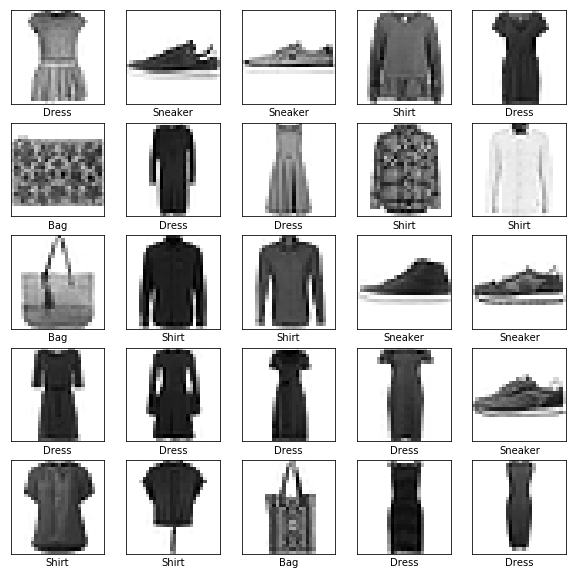

In [38]:
oos_classes = ['Dress', 'Shirt', 'Sneaker', 'Bag']
# Getting Class codes of the above mentioned category
modeling_index = [label_mapping[i] for i in oos_classes]
# Filtering based on the Class codes.
oos_x,oos_y = get_split(modeling_index,images,labels)
# Plotting Images to understanding
plot_data(label_mapping,oos_x,oos_y)

In [0]:
# Validation based on out of sample classes
test_labels = (3, 6, 7, 8)
# Finding Similar & Dissimilar pairs for classes mentioned.
oos_pairs_x, oos_pairs_y = finding_pairs(test_labels, oos_y,oos_x)

In [40]:
# Taking Prediciton using COmposit Network
y_pred = model.predict([oos_pairs_x[:, 0].reshape((oos_pairs_x.shape[0], 1,28, 28)), oos_pairs_x[:, 1].reshape((oos_pairs_x.shape[0], 1,28, 28))])
# Calculating Accuracy based on 60% cut off
te_acc = compute_accuracy(oos_pairs_y, y_pred)
print('* Accuracy on out-of-sample test set: %0.2f%%' % (100 * te_acc))

* Accuracy on out-of-sample test set: 69.74%
